# Shape Tech-Test

Author: Jonatas Cesar 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import pandas as pd
import shap
from catboost import CatBoostClassifier, Pool
from pandas_profiling import ProfileReport
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
%matplotlib inline

## 0 - Data profiling

In [3]:
df = pd.read_excel("O&G Equipment Data.xlsx", index_col="Cycle")
df[["Preset_1", "Preset_2"]] = df[["Preset_1", "Preset_2"]].astype("category")

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,800.0,69.263494,25.536252,2.089354,51.040134,65.906716,80.527220,255.607829
Pressure,800.0,78.997945,32.501834,3.480279,55.508564,75.014848,99.302530,189.995681
VibrationX,800.0,73.860275,31.229631,3.846343,50.752461,69.394953,90.195059,230.861142
VibrationY,800.0,72.786878,32.739745,10.057744,48.523982,65.504770,94.075572,193.569947
VibrationZ,800.0,71.866211,27.844616,18.784169,50.787638,69.319237,88.891205,230.951134
Frequency,800.0,68.223449,29.138702,4.380101,45.861762,65.664252,90.097457,178.090303


In [5]:
# check imbalanced data
df.Fail.mean()

0.0825

In [6]:
profile = ProfileReport(df, title="Shape Data - Profiling Report", minimal=True)

In [7]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## 1 - Calculating how many times the equiment has failed

In [8]:
pd.DataFrame(df.Fail.value_counts())

,Fail
False,734
True,66


## 2 - Categorize equipment failures by setups configurations (preset 1 and preset 2)

In [9]:
def eval_presetfail(df, preset_col):
    preset_fail = (
        pd.DataFrame(df.loc[:, [preset_col, "Fail"]].value_counts(), columns=["Counts"])
        .reset_index()
        .pivot(index=preset_col, columns="Fail", values="Counts")
    )

    preset_fail.columns = ["Not Fail Count", "Fail Count"]

    preset_fail["Fail rate"] = preset_fail.loc[:, "Fail Count"] / (
        preset_fail.loc[:, "Not Fail Count"] + preset_fail.loc[:, "Fail Count"]
    )
    return preset_fail

In [10]:
eval_presetfail(df, "Preset_1")

,Not Fail Count,Fail Count,Fail rate
Preset_1,,,
1,237,27,0.102273
2,260,21,0.074733
3,237,18,0.070588


In [11]:
eval_presetfail(df, "Preset_2")

,Not Fail Count,Fail Count,Fail rate
Preset_2,,,
1,84,11,0.115789
2,92,9,0.089109
3,95,6,0.059406
4,90,3,0.032258
5,88,12,0.120000
6,92,9,0.089109
7,100,9,0.082569
8,93,7,0.070000


## 3 – Categorize equipment failures by their nature/root cause according to parameter readings

In [12]:
parameter_readings = [
    "Temperature",
    "Pressure",
    "VibrationX",
    "VibrationY",
    "VibrationZ",
    "Frequency",
]

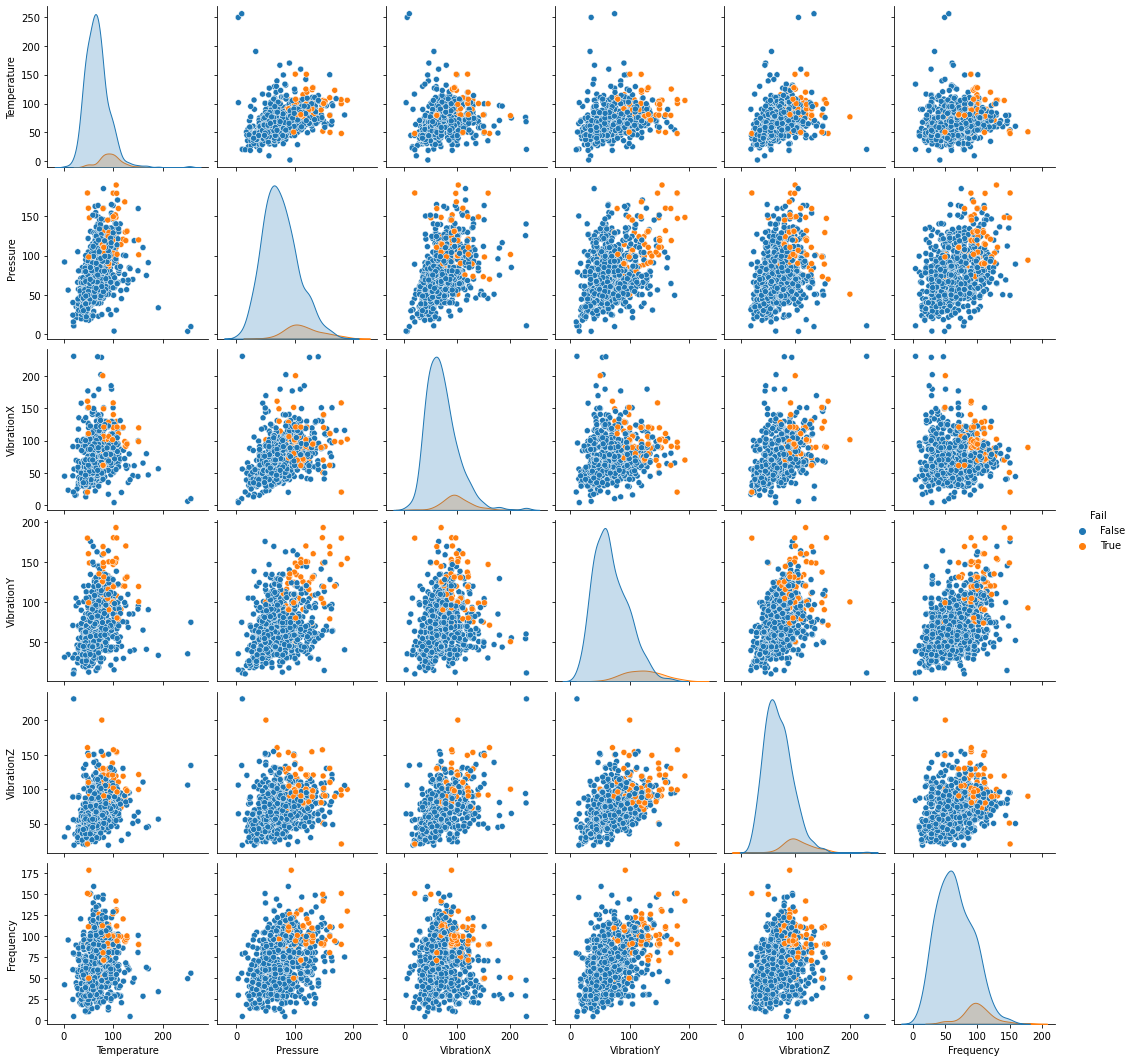

In [13]:
sns.pairplot(df.loc[:, parameter_readings + ["Fail"]], hue="Fail")
plt.show()

In [14]:

mean_readings = df.groupby("Fail").mean().T
mean_readings.columns = ["Not Fail Avg", "Fail Avg"]
mean_readings["Avg Increase (%)"] = 100 * (
    mean_readings["Fail Avg"] / mean_readings["Not Fail Avg"] - 1
)
mean_readings

,Not Fail Avg,Fail Avg,Avg Increase (%)
Temperature,67.176884,92.469125,37.650215
Pressure,75.632790,116.422540,53.931304
VibrationX,71.494803,100.167190,40.104156
VibrationY,68.318455,122.481159,79.279754
VibrationZ,68.796672,106.003200,54.081872
Frequency,65.382995,99.812745,52.658569


## 4 - Create a model using the technique you think is most appropriate and measure its performance 

### 4.1 - Split Data

In [15]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 4.2 - Model Fit 

In [17]:
model = CatBoostClassifier()

In [18]:
cat_features = ["Preset_1", "Preset_2"]

In [19]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
)

### 4.3 - Classification perfomance

In [20]:
y_pred_prob = model.predict(X_test, prediction_type="Probability")[:, 1]

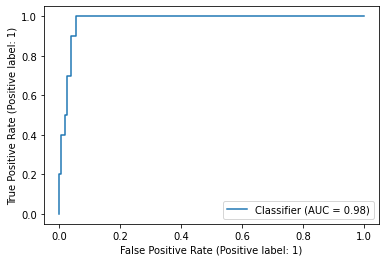

In [21]:
RocCurveDisplay.from_predictions(y_test.values, y_pred_prob)
plt.show()

In [22]:
y_pred = y_pred_prob > 0.5

In [23]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       150
        True       0.64      0.70      0.67        10

    accuracy                           0.96       160
   macro avg       0.81      0.84      0.82       160
weighted avg       0.96      0.96      0.96       160



## 5 - Analyze variable importance

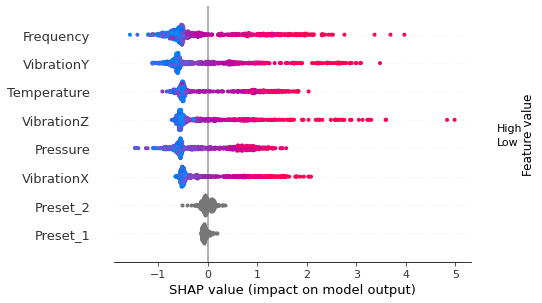

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))
shap.summary_plot(shap_values, X_train)